In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e13/sample_submission.csv
/kaggle/input/playground-series-s3e13/train.csv
/kaggle/input/playground-series-s3e13/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split,KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy

In [3]:
rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s3e13/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e13/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s3e13/sample_submission.csv')

In [5]:
def do_pca(df):
    
    df = df.drop('id',axis = 1)
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    pca = PCA(n_components = 5, random_state = 42)
    
    X = pd.DataFrame(pca.fit_transform(X))
    
    X['target'] = y
    
    return X
    

In [6]:
train = do_pca(train)

In [7]:
df = train.copy()

<Figure size 1500x1500 with 0 Axes>

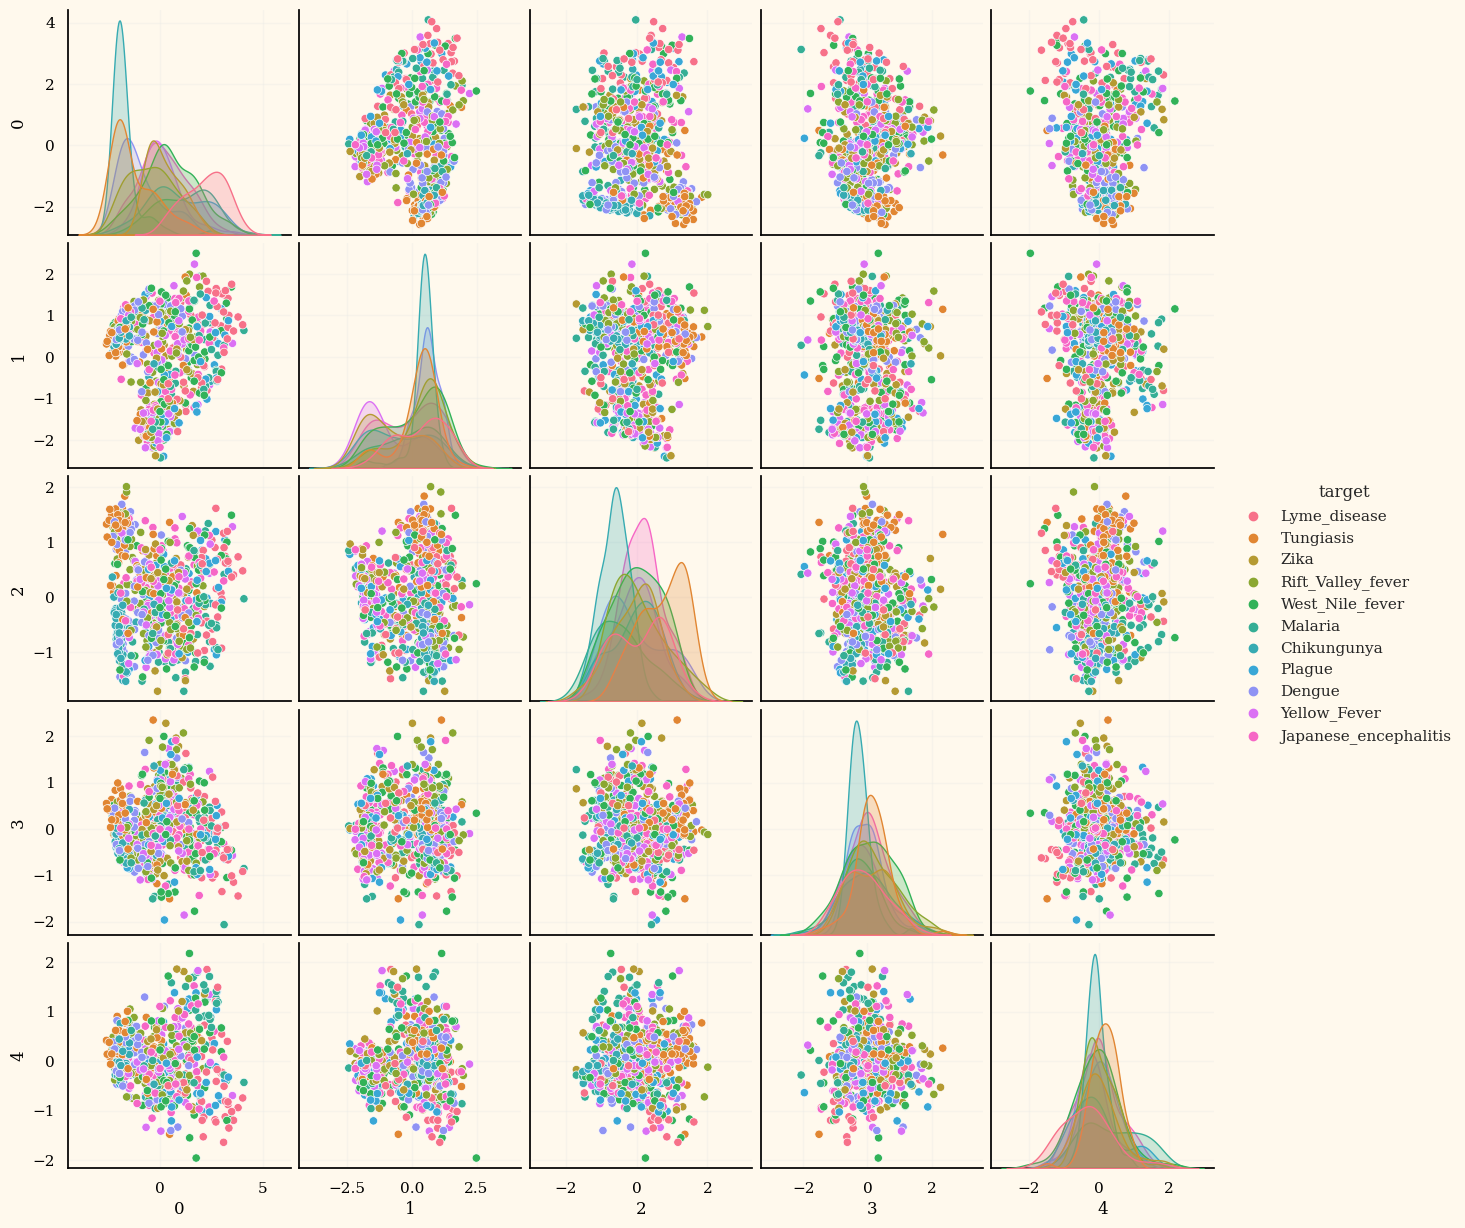

In [8]:
plt.figure(figsize = (15,15))

sns.pairplot(df,
            hue = 'target')

In [9]:
X = df.iloc[:,:-1]
y = df[['target']]

In [10]:
enc = OrdinalEncoder()

y = to_categorical(enc.fit_transform(y))

N_CLASSES = len(enc.categories_[0])

In [11]:
x_train,x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 42)

In [12]:
def create_model(INPUT_SHAPE,
                FIRST_NODE,
                LAYERS,
                HIDDEN_NODE,
                L2,
                DROPOUT_RATE,
                OUTPUT_SHAPE):
    
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(FIRST_NODE, activation='relu')(x)
    
    for _ in range(LAYERS):
        x = layers.BatchNormalization()(x)
        x = layers.Dense(HIDDEN_NODE,kernel_regularizer = regularizers.l2(L2),
                         activation='relu')(x)
        x = layers.Dropout(DROPOUT_RATE)(x)
        
    outputs = layers.Dense(OUTPUT_SHAPE, activation = 'softmax')(x)
    
    return keras.Model(inputs,outputs)

In [13]:
params = {'INPUT_SHAPE':x_train.shape[1:],
            'FIRST_NODE':64,
            'LAYERS':3,
            'HIDDEN_NODE':32,
            'L2': 0.01,
            'DROPOUT_RATE':0.3,
            'OUTPUT_SHAPE':N_CLASSES}

optimizers = {'loss': CategoricalCrossentropy(),
              'optimizer': tf.keras.optimizers.legacy.Adam(learning_rate = 0.01),
              'metrics':['accuracy']}


model = create_model(**params)

model.compile(**optimizers)

In [14]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 30)

In [15]:
history = model.fit(x_train,y_train,
                   validation_data = (x_test,y_test),
                   epochs = 9999,
                   callbacks = [early_stopping])

Epoch 1/9999
18/18 [==============================] - 5s 25ms/step - loss: 3.4503 - accuracy: 0.1487 - val_loss: 3.2053 - val_accuracy: 0.2113
Epoch 2/9999
18/18 [==============================] - 0s 8ms/step - loss: 3.0674 - accuracy: 0.1699 - val_loss: 2.9589 - val_accuracy: 0.2113
Epoch 3/9999
18/18 [==============================] - 0s 8ms/step - loss: 2.7448 - accuracy: 0.1876 - val_loss: 2.7476 - val_accuracy: 0.1972
Epoch 4/9999
18/18 [==============================] - 0s 8ms/step - loss: 2.5581 - accuracy: 0.2230 - val_loss: 2.6288 - val_accuracy: 0.1972
Epoch 5/9999
18/18 [==============================] - 0s 8ms/step - loss: 2.4246 - accuracy: 0.2389 - val_loss: 2.5128 - val_accuracy: 0.1972
Epoch 6/9999
18/18 [==============================] - 0s 8ms/step - loss: 2.3134 - accuracy: 0.2655 - val_loss: 2.4408 - val_accuracy: 0.2606
Epoch 7/9999
18/18 [==============================] - 0s 8ms/step - loss: 2.2896 - accuracy: 0.2478 - val_loss: 2.4162 - val_accuracy: 0.2113
Epoch

In [16]:
def make_plot(history):
    
    fig,ax = plt.subplots(ncols = 2, figsize = (15,5))
    
    ax[0].plot(history.history['loss'], label = 'train_loss', c = 'orange')
    ax[0].plot(history.history['val_loss'], label = 'valid_loss', c = 'red')
    ax[0].legend(loc = 'upper right')
    ax[0].set_title('train,valid loss')
    
    ax[1].plot(history.history['accuracy'], label = 'train_accuracy', c = 'orange')
    ax[1].plot(history.history['val_accuracy'], label = 'valid_accuracy', c = 'red')
    ax[1].legend(loc = 'lower right')
    ax[1].set_title('train,valid accuracy')
    
    

In [17]:
def mpk(y_test, predicted):
    """
    Calculates the mean precision at k for a given set of predictions.
    Args:
        y_test (np.ndarray): Actual values for the test set
        predicted (np.ndarray): Predicted values for the test set
    Returns:
        mpk_score (float): Mean precision at k score for the test set
    """
    k = 3
    mpk_score = 0
    for i, y in enumerate(y_test):
        top_k_preds = predicted[i].argsort()[-k:][::-1]
        mpk_score += np.mean([1 if np.argmax(y) in top_k_preds[:j+1] else 0 for j in range(k)])
    mpk_score /= len(y_test)
    return mpk_score

5/5 [==============================] - 0s 2ms/step


Text(0.5, 0.98, 'MPK : 0.397')

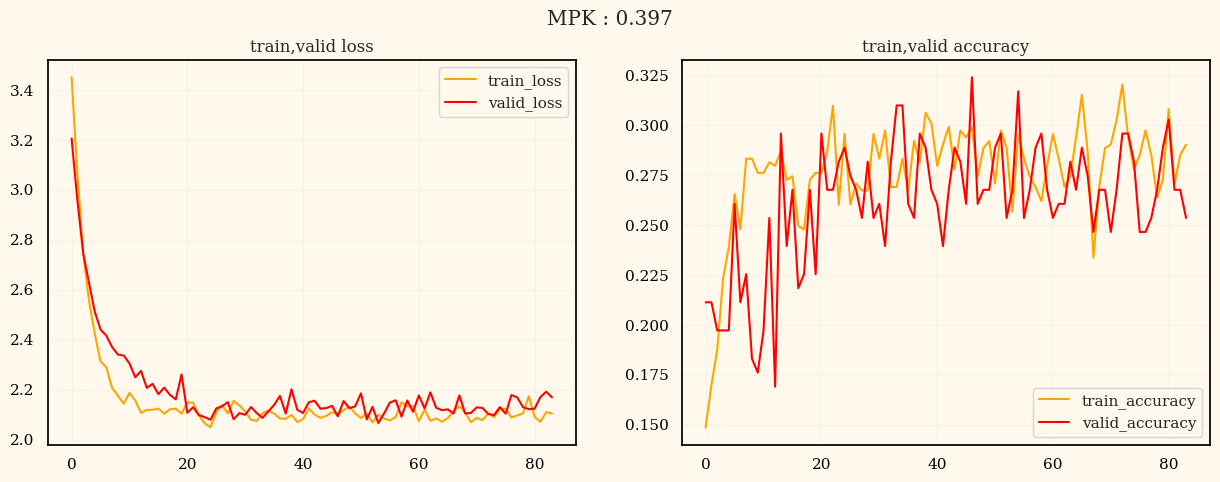

In [18]:
make_plot(history)
plt.suptitle(f'MPK : {mpk(y_test,model.predict(x_test)):.3f}')

In [19]:
pca = PCA(n_components = 5, random_state = 42)

test = pca.fit_transform(test.drop('id',axis = 1))

In [20]:
def make_sub(probs):
    
    result = []
    
    for prob in probs:
        
        result.append(prob.argsort()[-3:][::-1])
        
    reverse = {}
    
    for i,cate in enumerate(enc.categories_[0]):
        
        reverse[i] = cate
        
        
    df = pd.DataFrame(result)
    
    to_sub = df[0].map(reverse) + ' ' + df[1].map(reverse) + ' ' + df[2].map(reverse)
    
    return to_sub
    
    
        
    
    

In [21]:
sub['prognosis'] = make_sub(model.predict(test))

10/10 [==============================] - 0s 2ms/step


In [22]:
sub

,id,prognosis
0,707,Chikungunya Dengue West_Nile_fever
1,708,Japanese_encephalitis Tungiasis Rift_Valley_fever
2,709,Japanese_encephalitis West_Nile_fever Rift_Val...
3,710,Rift_Valley_fever West_Nile_fever Dengue
4,711,West_Nile_fever Japanese_encephalitis Rift_Val...
...,...,...
298,1005,West_Nile_fever Rift_Valley_fever Japanese_enc...
299,1006,Lyme_disease Malaria Plague
300,1007,Lyme_disease Malaria Plague
301,1008,Japanese_encephalitis West_Nile_fever Rift_Val...


In [23]:
sub.to_csv('pca_5.csv', index = False)